In [1]:
import cx_Oracle
import pandas as pd

In [2]:
def connect_to_db(username='CSM', password='ghi22OGJELOB2f', host='172.16.16.11', port=1521,
                         service_name='CSM_BM'):
    # Connect to Oracle DB
    db_conn_str = username + '/' + password + '@' + host + ':' + str(port) + '/' + service_name
    return cx_Oracle.connect(db_conn_str)

In [3]:
# 连接营收数据库
connector = connect_to_db()
cursor = connector.cursor()
start_month = 202301
end_month = 202312
# !!! SQL语句末尾不能加分号(;)
instruction = f"SELECT c.subcom_code, c.card_id, c.card_name, c.card_address, c.location_cs_lt, c.location_cs_lg, sum(r.read_water) \
                FROM csm.cm_metercards c \
                INNER JOIN csm.mr_record r ON c.card_id = r.card_id \
                WHERE c.location_cs_lg IS NOT NULL \
                      AND r.record_state = 4 \
                      AND r.billing_month BETWEEN {start_month} AND {end_month} \
                GROUP BY c.subcom_code, c.card_id, c.card_name, c.card_address, c.location_cs_lt, c.location_cs_lg"
cursor.execute(instruction)

<cx_Oracle.Cursor on <cx_Oracle.Connection to CSM@172.16.16.11:1521/CSM_BM>>

In [4]:
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['subcompany', 'card_id', 'card_name', 'card_addr', 'latitude', 'longitude', 'water_usage'])

In [5]:
df.head(10)

,subcompany,card_id,card_name,card_addr,latitude,longitude,water_usage
0,051,0001543305,蔡润贵,沙区仓房沟一队水泥厂街北巷6井（东南2表）,4846737.06,546913.88,1575
1,051,0001543605,王梅姿,沙区---沙区仓房沟一队水泥厂街北巷6井（西南1表）,4846736.96,546913.14,626
2,051,0000118305,新疆广汇物业管理有限公司沙依巴克区分公司,沙区黑龙江路,4850956.99,547974.53,11873
3,031,3001650303,乌鲁木齐市第六十中学,水磨沟区六道湾路-东二巷101号,4856073.36,551150.89,11202
4,051,0001171605,新疆雅露达商业投资有限责任公司,沙区克西路同井（东北表）,4853609.94,544576.67,20537
5,051,0000719905,乌鲁木齐环投城市清洁有限公司,沙区---沙区西山路58号,4852071.14,545446.77,12842
6,051,0000104605,乌鲁木齐市福乐达汽车服务有限公司,沙区---沙区九家湾八农后门（东表）,4853061.95,545028.42,0
7,031,0000640503,新疆海大物业服务有限公司,水磨沟区安居南路西二巷-..,4853954.29,548702.97,122170
8,031,0000012703,乌鲁木齐市机关事务管理局,水磨沟区南湖路,4854076.99,549117.38,2842
9,031,0000475203,乌鲁木齐博万智慧城市运营管理有限公司,水磨沟区---水磨沟区克东路1316号,4854381.30,549172.31,1535


In [57]:
import matplotlib.pyplot as plt

water_usage = df.copy()

# 删除文字列
water_usage.drop("card_name", axis=1, inplace=True)
water_usage.drop("card_addr", axis=1, inplace=True)

# 对于经纬度录反的坐标进行交换
condition = water_usage["latitude"] > water_usage["longitude"]
water_usage.loc[condition, "latitude"], water_usage.loc[condition, "longitude"] = \
    water_usage.loc[condition, "longitude"], water_usage.loc[condition, "latitude"]

water_usage.head()

,subcompany,card_id,latitude,longitude,water_usage
0,051,0001543305,546913.88,4846737.06,1575
1,051,0001543605,546913.14,4846736.96,626
2,051,0000118305,547974.53,4850956.99,11873
3,031,3001650303,551150.89,4856073.36,11202
4,051,0001171605,544576.67,4853609.94,20537


In [72]:
from sklearn.preprocessing import StandardScaler

# 对数据进行标准化处理
std_scaler = StandardScaler()
water_usage_std_scaled = water_usage.copy()
water_usage_std_scaled["latitude"] = std_scaler.fit_transform(water_usage[["latitude"]])
water_usage_std_scaled["longitude"] = std_scaler.fit_transform(water_usage[["longitude"]])
water_usage_std_scaled["water_usage"] = std_scaler.fit_transform(water_usage[["water_usage"]])

water_usage_std_scaled

,subcompany,card_id,latitude,longitude,water_usage
0,051,0001543305,-0.221739,-1.511705,-0.179072
1,051,0001543605,-0.221919,-1.511725,-0.200535
2,051,0000118305,0.036804,-0.696410,0.053830
3,031,3001650303,0.811072,0.292078,0.038655
4,051,0001171605,-0.791456,-0.183858,0.249778
...,...,...,...,...,...
15473,041,0000192204,-1.601701,0.933650,-0.214693
15474,051,3000232415,0.081425,-0.741724,-0.214648
15475,051,3000206115,-0.133069,-0.903043,-0.214670
15476,031,3000353113,0.843166,0.211302,-0.214625


F:\Projects\Work\py310\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


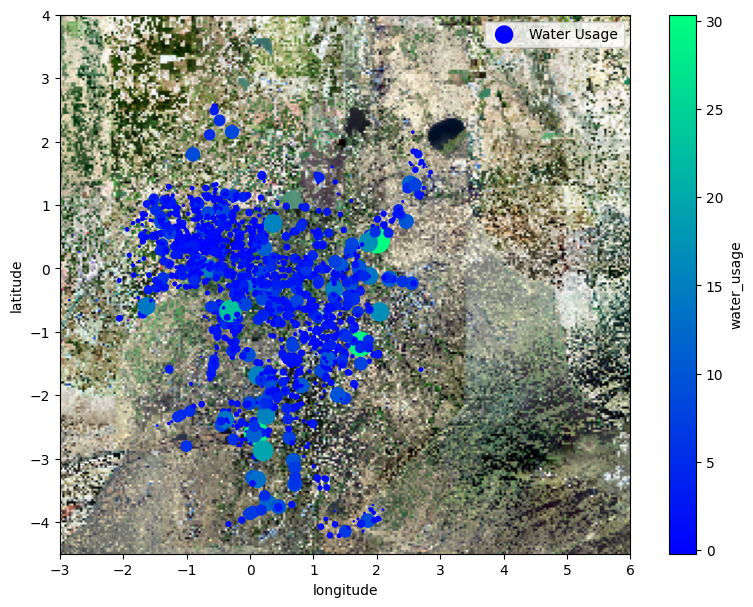

In [79]:
import os

water_usage_std_scaled.plot(kind="scatter", x="longitude", y="latitude",
                 s=water_usage_std_scaled["water_usage"]*10, label="Water Usage",
                 c="water_usage", cmap="winter", colorbar=True,
                 legend=True, sharex=False, figsize=(10, 7))

current_dir = os.getcwd()
filename = "urumqi_map.png"
urumqi_map = plt.imread(os.path.join(current_dir, filename))
axis = -3, 6, -4.5, 4
plt.axis(axis)
plt.imshow(urumqi_map, extent=axis)

plt.show()